**Script Name:** 3D Reconstruction (Public).ipynb </br>
**Description:** This script is used for reconstructing a 3D geometry based on 2D images. </br>
**Author:** Jetsada Arnin, PhD </br>
**Date:** March 22, 2023 </br>
*Copyright (c) 2023 Jetsada Arnin*


In [1]:
#@title Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go

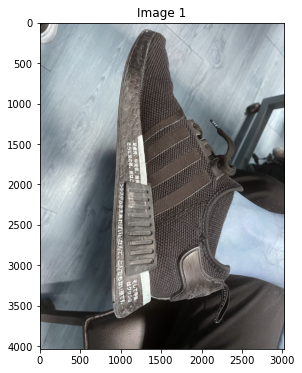

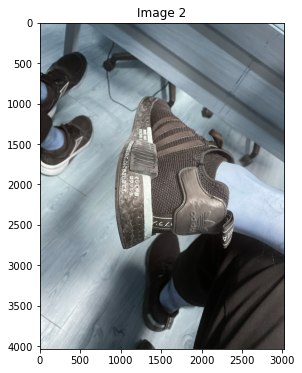

In [2]:
#@title Step 1: Load the two 2D images
# Load the images
img1 = cv2.imread("./im/pair3/IMG_1151.jpg")
img2 = cv2.imread("./im/pair3/IMG_1154.jpg")

# Convert the images to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Display the images
plt.figure(figsize=(8, 6))
plt.imshow(img1)
plt.title('Image 1')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(img2)
plt.title('Image 2')
plt.show()

In [3]:
#@title Step 2: Calibrate the camera to get the camera matrix
# Note: You need to provide the camera's intrinsic parameters, including focal length (fx, fy) and optical center (cx, cy).

# Estimate the focal length in pixels using an object of known dimensions and its distance from the camera
"""get from the camera"""
"""In the example, it is assumed from the image"""
real_object_dimension = 0.32  # The real-world width or height of the object (in meters) 
"""From camera to obj"""
distance_to_object = 0.25  # The distance from the camera to the object (in meters)
"""Img height x width"""
object_dimension_pixels = 2750  # The width or height of the object in pixels

# Calculate the focal length in pixels
focal_length_pixels = (object_dimension_pixels * distance_to_object) / real_object_dimension

# Construct the camera matrix (K) using the estimated focal length
fx, fy = focal_length_pixels, focal_length_pixels
cx, cy = gray1.shape[1] // 2, gray1.shape[0] // 2  # Optical center (assuming it's the center of the image)

# Define the camera matrix K
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]], dtype=np.float32)

print('K = ', K)

K =  [[2.1484375e+03 0.0000000e+00 1.5120000e+03]
 [0.0000000e+00 2.1484375e+03 2.0160000e+03]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]


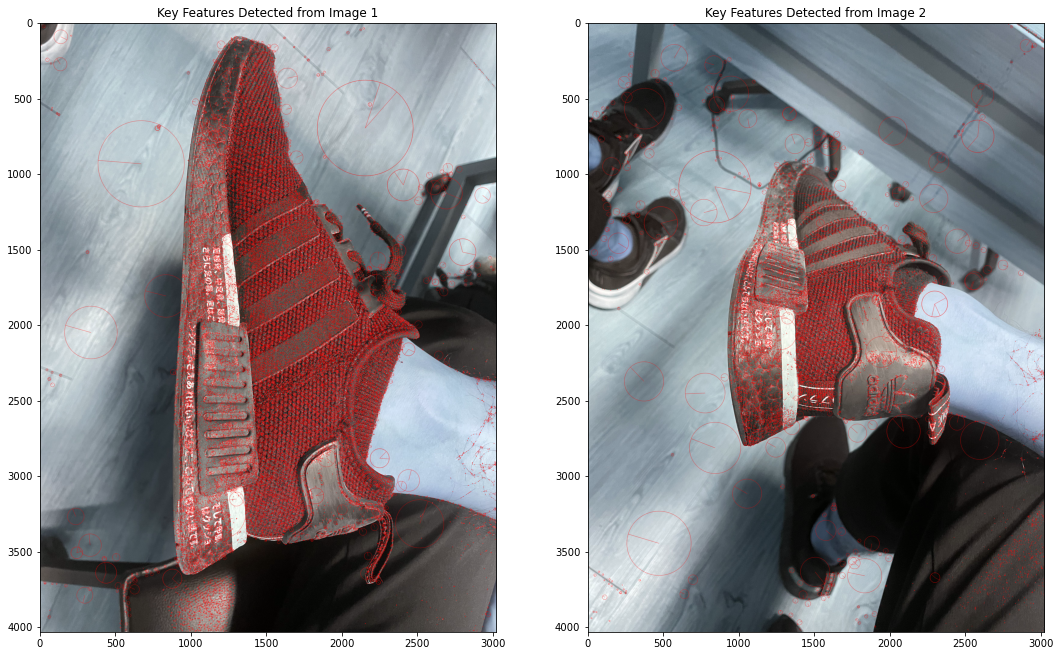

In [4]:
#@title Step 3: Extract features from the images using a feature detector (e.g., SIFT)
# Create a SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Draw the key features detected from each image
img1_kp = cv2.drawKeypoints(img1, kp1, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(img2, kp2, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the key features
plt.figure(figsize=(18, 15))
plt.subplot(121), plt.imshow(img1_kp), plt.title('Key Features Detected from Image 1')
plt.subplot(122), plt.imshow(img2_kp), plt.title('Key Features Detected from Image 2')
plt.show()

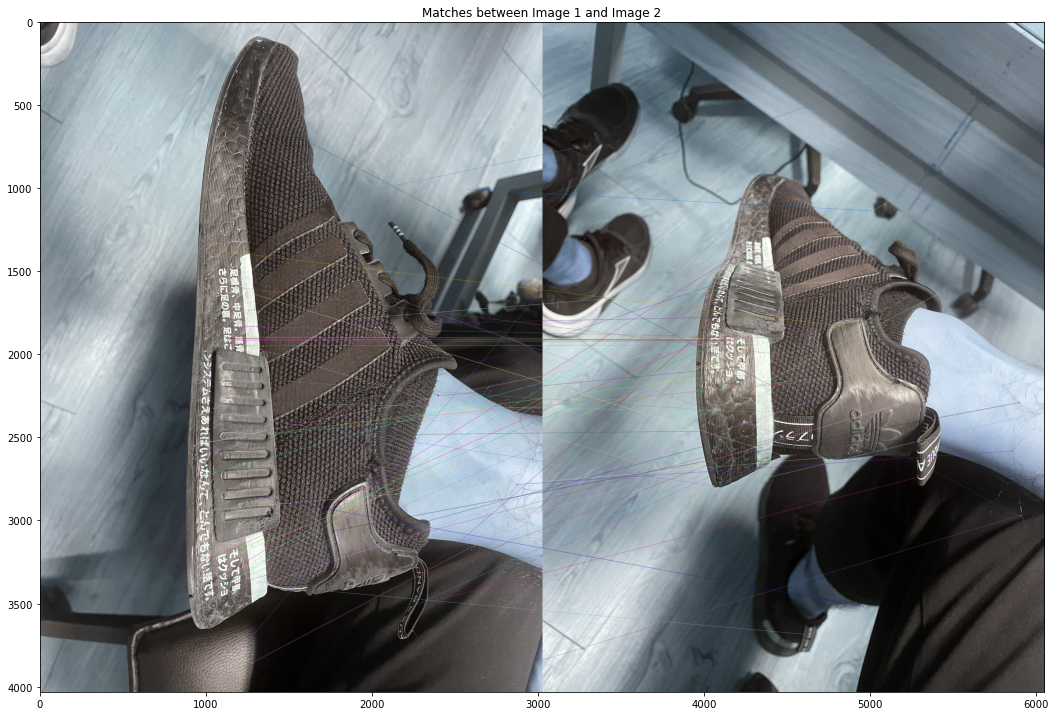

In [5]:
#@title Step 4: Match features between the two images
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply the ratio test to filter good matches
good_matches = []
for m, n in matches:
    """The closer to 0, the more match we may get"""
    if m.distance < 0.8 * n.distance: 
        good_matches.append(m)

# Extract the matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Draw the matches between the two images
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
plt.figure(figsize=(18, 15))
plt.imshow(img3)
plt.title('Matches between Image 1 and Image 2')
plt.show()

In [44]:
#@title Step 5: Estimate the essential matrix using the matched feature points and the camera matrix
E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
print('E = ', E)

E =  [[ 0.68876247  0.01313336 -0.05966801]
 [ 0.01976275 -0.6725353   0.21099051]
 [ 0.14926375 -0.0486956   0.00336114]]


In [45]:
#@title Step 6: Recover the camera pose (rotation and translation) from the essential matrix
_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K, mask=mask)
print('R = ', R)
print('\nt = ', t)

R =  [[-0.02698785  0.99535216 -0.09244316]
 [ 0.9996052   0.02614826 -0.01028163]
 [-0.00781661 -0.09268414 -0.99566488]]

t =  [[-0.20915788]
 [-0.07468221]
 [ 0.97502592]]


In [46]:
#@title Step 7: Triangulate the matched feature points to get the 3D points
# Create projection matrices for both cameras
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = K @ np.hstack((R, t))

# Triangulate points
homogeneous_points_3D = cv2.triangulatePoints(P1, P2, pts1, pts2)
points_3D = cv2.convertPointsFromHomogeneous(homogeneous_points_3D.T)

print(points_3D.shape)

(6, 1, 3)


In [47]:
#@title Step 8 : Convert the camera poses to the world coordinate
# Function to create camera axes
def create_camera_axes(E, C, scale=1):
    axis_lines = []
    for i in range(3):
        p1 = C
        p2 = C + scale * E[:, i]
        axis_lines.append(
            go.Scatter3d(x=[p1[0], p2[0]], y=[p1[1], p2[1]], z=[p1[2], p2[2]],
                         mode='lines', line=dict(width=5, color='rgb(255, 0, 0)' if i == 0 else ('rgb(0, 255, 0)' if i == 1 else 'rgb(0, 0, 255)')))
        )
    return axis_lines

# Define camera poses
E1 = np.hstack((np.eye(3), np.zeros((3, 1))))
E2 = np.hstack((R, t))
C1 = -np.linalg.inv(E1[:, :3]) @ E1[:, 3]
C2 = -np.linalg.inv(E2[:, :3]) @ E2[:, 3]

# Create camera axes in world coordinates
camera1_axes = create_camera_axes(E1[:, :3], C1, scale=0.5)
camera2_axes = create_camera_axes(E2[:, :3], C2, scale=0.5)

In [48]:
#@title Step 9 : Visualize the camera pose and 3D points in the same plot using Plotly
# Create camera pose visualization
camera_cones = [go.Cone(x=[C1[0], C2[0]], y=[C1[1], C2[1]], z=[C1[2], C2[2]],
                        u=[E1[0, 0], E2[0, 0]], v=[E1[1, 0], E2[1, 0]], w=[E1[2, 0], E2[2, 0]],
                        sizemode='scaled', sizeref=0.2, anchor='tail', colorscale='Viridis', showscale=False)]

# Create a scatter plot for the 3D points
scatter_3d = go.Scatter3d(x=points_3D[:, 0, 0], y=points_3D[:, 0, 1], z=points_3D[:, 0, 2],
                          mode='markers', marker=dict(size=2, color='red'))

# Create a layout and plot the data
layout = go.Layout(scene=dict(aspectmode='data'), autosize=False, width=1000, height=600)
fig = go.Figure(data=[scatter_3d, *camera_cones], layout=layout)
fig.show()